# CS342 Final Project
### Dayou Ren; Spencer Petty
### dr37269; sap3758

In this project, we will be building and training an autoencoder architecture to generate images of CS professor. We are basically asking this question: "what does a neural network believe a CS professor should look like?"

# Imports

In [4]:
import torchvision
import torch

from training import train_vae
from netclasses import ConvTVAE
from testfuncs import test_model

# Training

In [17]:
nepochs_pre = 1
nepochs_main = 64
latent_dims = 64
hnodes = 256

linmodel = ConvTVAE(latent_dims,hnodes)

  0%|          | 0/1 [00:00<?, ?epoch/s]

  0%|          | 0/201 [00:00<?, ?batch/s]

Exited from training early


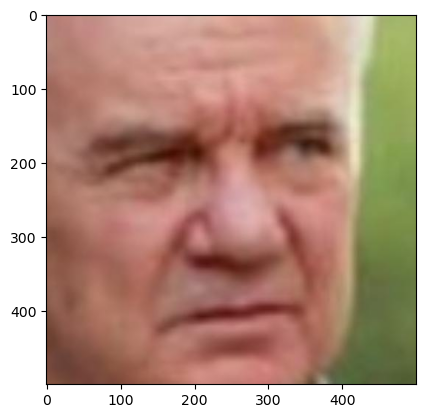

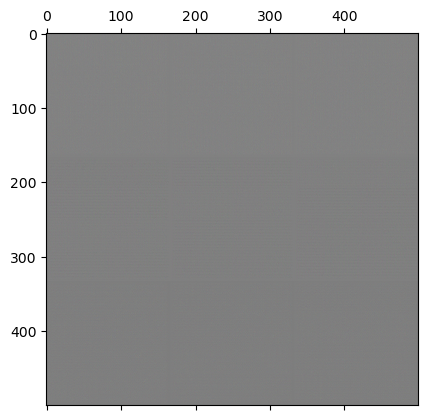

In [18]:
pretrainset = torchvision.datasets.ImageFolder('./lfwdatacolor', transform=torchvision.transforms.ToTensor())
pretrainloader = torch.utils.data.DataLoader(pretrainset, batch_size=64, shuffle=True)
train_vae(linmodel, pretrainloader, nepochs = nepochs_pre, regularize=False)
yhat = test_model(model = linmodel)

  0%|          | 0/64 [00:00<?, ?epoch/s]

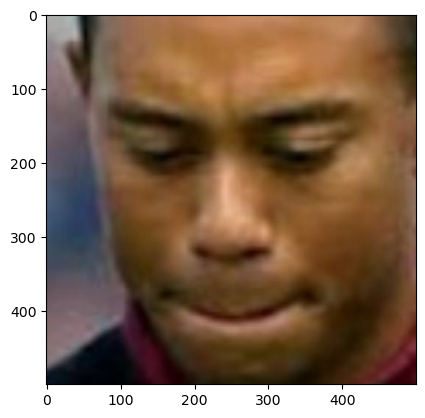

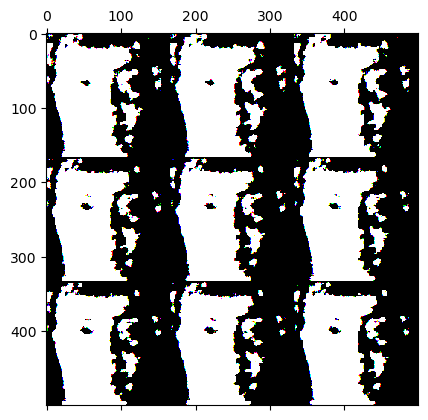

In [ ]:
trainset  = torchvision.datasets.ImageFolder('./profdatacolor', transform = torchvision.transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 48, shuffle=True)
train_vae(linmodel, trainloader, nepochs = nepochs_main, regularize=False)
test_model(model = linmodel)
torch.save(linmodel.state_dict(), "models/overhauled_tconv/desc.txt")